### Tests

In [36]:
import sys, os
sys.path.append('../../src')

import astropy.coordinates as coord
from astropy.io.votable import parse
from astropy.table import Table

import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np

import gaia_utils as gu
from sklearn.cluster import KMeans

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/master/notebooks/data"%(rootdir)

os.chdir(wdir)

In [37]:
from astroquery.gaia import Gaia

# tables = Gaia.load_tables(only_names=True)

#for table in (tables):
#    print (table.get_qualified_name())
    

In [38]:
c = coord.SkyCoord.from_name("M47")
c = coord.SkyCoord.from_name("NGC 2682")
radius = 2.0

queryaql = "SELECT * FROM gaiadr2.gaia_source WHERE \
CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS' \
,%f ,%f,%f))=1;"%(c.ra.deg+radius/10.,c.dec.deg+radius/10.,radius)

job = Gaia.launch_job_async( queryaql, dump_to_file=True)
# print (job)

# r = job.get_results()


Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS' ,133.025000 ,12.000000,2.000000))=1;'
Retrieving async. results...


In [39]:
## Filter the data
##

def plot_check(a1, a2, ifinal):
    "check the filltering"
    
    
    rcParams['figure.figsize'] = 14, 14
    f, axarr = plt.subplots(2, 2)

# ax.scatter(cluster_candidates["ra"], cluster_candidates["dec"], s=1, c="#000000")
    print(len(a1))
    print(len(a2))
    
    axarr[0,0].scatter(a1, a2, s=1, c="#000000")
    axarr[0,0].set_xlabel("a1")
    axarr[0,0].set_ylabel("a2")
    axarr[0,0].set_ylim([0,2000])

    axarr[0,1].scatter(a1[ifinal], a2[ifinal], s=1, c="#000000")
    axarr[0,1].set_xlabel("a1[ifinal]")
    axarr[0,1].set_ylabel("a2[ifinal]")

    plt.show()
    
def filter_data(lgal, bgal, distance, vra, vdec, dist_range = [0., 2000], vra_range = [-200,200], vdec_range = [-200.,200]):
    "filter the data applying the range and return the sklearn-centric array"
    
    i1 = np.where((distance >= dist_range[0]) & (distance < dist_range[1]))
    i2 = np.where((vra >= vra_range[0]) & (vra < vra_range[1]))
    i12 = np.intersect1d(i1,i2)
    i3 = np.where((vdec >= vdec_range[0]) & (vdec < vdec_range[1]))
    ifinal = np.intersect1d(i12,i3)
    
    plot_check(lgal,vra,ifinal)
    
    datask = np.zeros((len(ifinal),5))
    
    datask[:,0] = lgal[ifinal]
    datask[:,1] = bgal[ifinal]
    datask[:,2] = distance[ifinal]
    datask[:,3] = vra[ifinal]
    datask[:,4] = vdec[ifinal]
    
    return(datask)
    
    

('solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

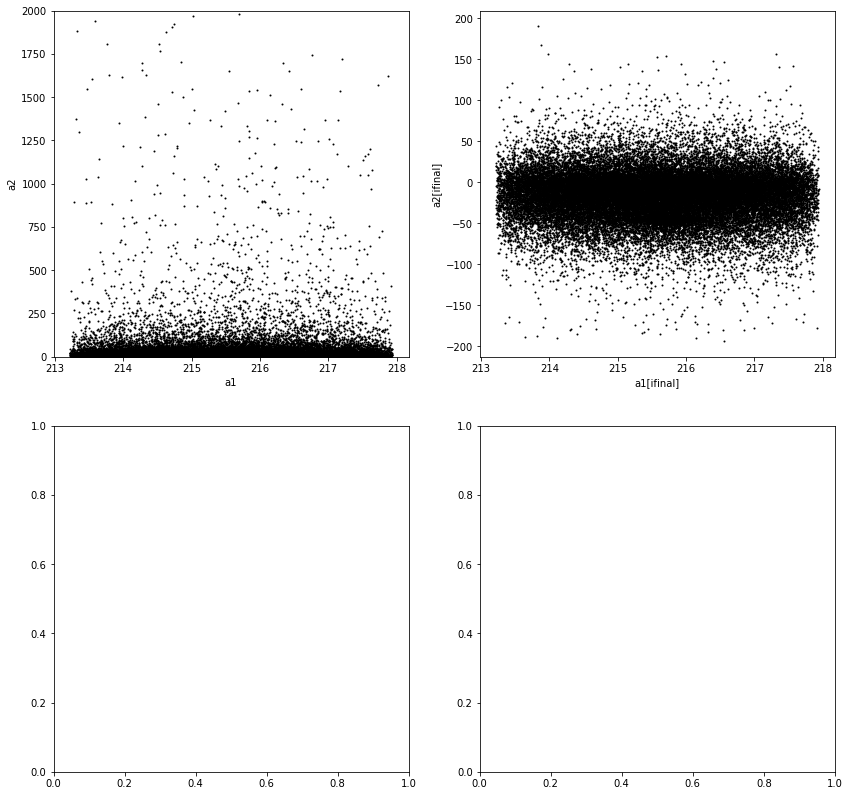

## Stars selected: 37627
## computing k-means...
## Centroids:
[[ 215.5979739    32.11810878  394.03727444  -10.7055382   -16.01376265]
 [ 215.56219311   32.09174148 1412.16486266  -18.85121162  -24.76592639]
 [ 215.60775529   32.08122521  867.92289156  -22.16430492  -18.04210802]
 [ 215.57952782   32.09161685 1865.72702078  -21.47742061  -30.21977552]
 [ 215.57535659   32.08500898 1215.04393545  -18.51046024  -21.4308099 ]
 [ 215.5643555    32.07850268  705.92399723  -14.20295968  -17.81587291]
 [ 215.58724415   32.07091681 1627.17829299  -20.37780668  -27.41838146]
 [ 215.59025236   32.11142496  223.52629606   -9.57027204  -15.52076986]
 [ 215.56589464   32.08834233 1034.23477434  -17.89452947  -20.49375026]
 [ 215.55922587   32.09897892  549.52772144  -11.70437566  -16.55153469]]
## Label: 0, 4466 stars
## Label: 1, 3319 stars
## Label: 2, 5219 stars
## Label: 3, 2376 stars
## Label: 4, 3785 stars
## Label: 5, 4522 stars
## Label: 6, 2779 stars
## Label: 7, 2561 stars
## Label: 8, 3

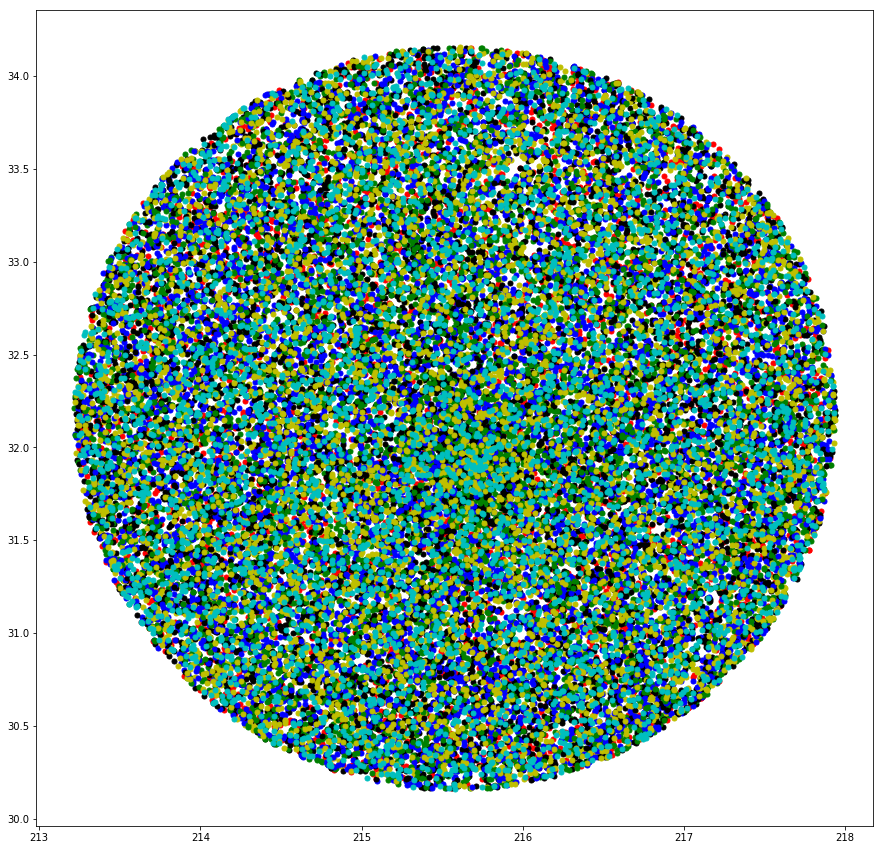

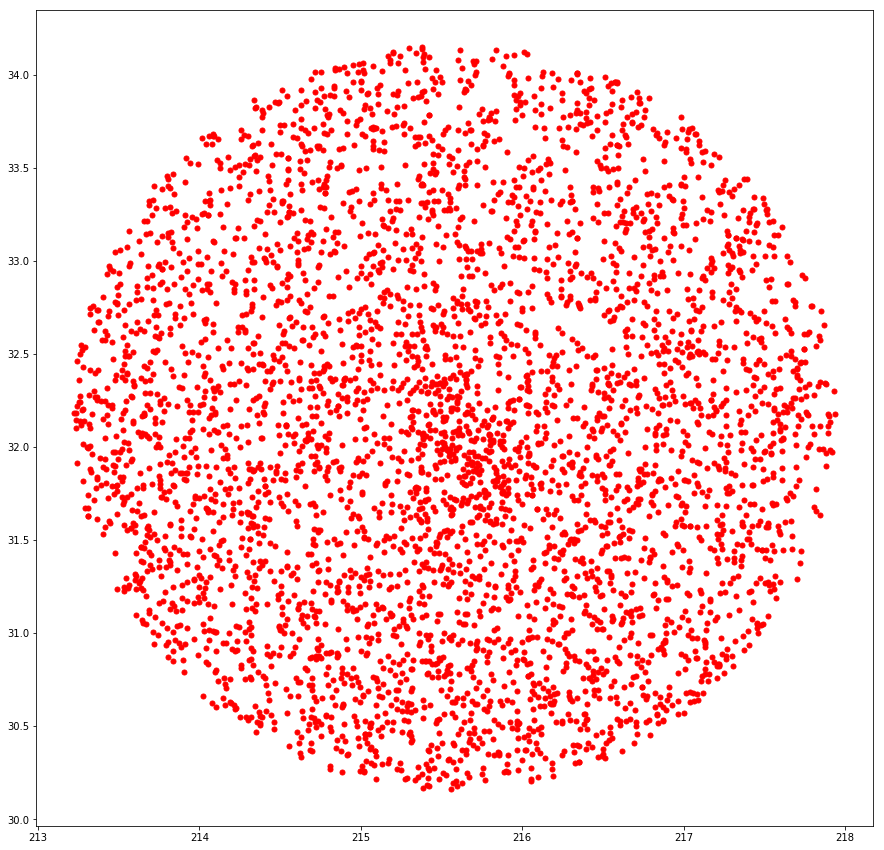

In [40]:
## Reading the votable

voname = "m47_off.vot"
voname = "ngc2682_2deg.vot"
votable = parse(voname)

for table in votable.iter_tables():
    data = table.array
    print(data.dtype.names)
    
lgal = data['l']
bgal = data['b']
pmas = data['parallax']
distance = 1000. / np.ma.filled(pmas, -9999.)
pmra = np.ma.filled(data['pmra'], -9999999.)
pmdec= np.ma.filled(data['pmdec'],-9999999.)
vdec = 4.74 * pmdec / pmas   ##?
vra  = 4.74 * pmra  / pmas


print("## Total stars: %d"%(len(lgal)))

## mashing the data ...
##


# datask = np.zeros((len(vra),5))
datask = filter_data(lgal,bgal,distance,vra,vdec)

print("## Stars selected: %d"%(len(datask[:,0])))

#datask[:,0] = lgal
#datask[:,1] = bgal
#datask[:,2] = distance
#datask[:,3] = vra
#datask[:,4] = vdec

nclust = 10
print("## computing k-means...")
kmeans = KMeans(n_clusters=nclust, max_iter = 500)
kmeans.fit(datask)

centroid = kmeans.cluster_centers_
labels = kmeans.labels_

print("## Centroids:")
print (centroid)
#print(labels)
for i in range(nclust):
    nstar = len(np.where(labels == i)[0])
    print("## Label: %d, %d stars"%(i,nstar))


colors = ["r.","k.","g.","y.","b.","k.","b.","g.","y.","c.","r.","k.","g.","y.","w.","k.","b.","g.","y.","c.","r.","k.","g.","y.","w.","k.","b.","g.","y.","c."]

rcParams['figure.figsize'] = 15, 15

for i in range(nclust):
    ilabel = np.where(labels == i)[0]
    plt.plot(datask[ilabel,0],datask[ilabel,1],colors[i],markersize=10)
    
plt.show()

labsel = 5
ilabel = np.where(labels == labsel)[0]
plt.plot(datask[ilabel,0],datask[ilabel,1],"r.",markersize=10)
plt.show()
    